# Currilulum Learning

This project used the Face Mask Detection dataset from Kaggle.

The data set will be divided into easy and difficult. It will compare models with divided and un-divided data.


In [1]:
import os
import cv2
import shutil
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from matplotlib.pyplot import imread
from sklearn.model_selection import train_test_split

DATA_DIR = "/content/drive/MyDrive/CS-body-head/"
print("TF version:", tf.__version__)

TF version: 2.14.0


In [2]:
print("GPU", "available" if tf.config.list_physical_devices("GPU") else "not available !")

GPU available


# **Preparation of data**

#### Data Conversion

In [3]:
def convert_xml_to_csv(xml_list):
  """
  Convert xml files to df and get x,y values
  Return dataframe and xmin-xmax and ymin-ymax
  """
  cols = ["filename", "width", "height","class", "xmin", "ymin", "xmax", "ymax"]
  rows = []

  for xml_file in xml_list:
    tree = ET.parse(xml_file)
    root = tree.getroot()

    for member in root.findall('object'):
      value = (root.find('filename').text,
      int(root.find('size')[0].text),
      int(root.find('size')[1].text),
      member[0].text,
      int(float(member.find('bndbox').find('xmin').text)),
      int(float(member.find('bndbox').find('ymin').text)),
      int(float(member.find('bndbox').find('xmax').text)),
      int(float(member.find('bndbox').find('ymax').text)))
      rows.append(value)
  df = pd.DataFrame(rows, columns=cols)

  return df,cols[4], cols[5], cols[6], cols[7]

In [4]:
"""
Convert xml files to csv
First value dataframes
"""
labels = [os.path.join(DATA_DIR, xml_filename)
          for xml_filename in os.listdir(DATA_DIR)
          if xml_filename.endswith("xml")]

results = convert_xml_to_csv(labels)
labels_csv = results[0]
labels_csv.to_csv("labels.csv", index=None)
print(labels_csv.head())

        filename  width  height class  xmin  ymin  xmax  ymax
0  image-100.jpg    535     300  body   261   148   276   179
1  image-100.jpg    535     300  body    46   151    60   161
2  image-100.jpg    535     300  head    50   151    55   157
3  image-100.jpg    535     300  head   266   148   270   155
4  image-102.jpg    535     300  body    45   151    68   190


#### Check Data

In [5]:
filenames = [DATA_DIR + fname for fname in labels_csv["filename"]]
filenames[:10]

['/content/drive/MyDrive/CS-body-head/image-100.jpg',
 '/content/drive/MyDrive/CS-body-head/image-100.jpg',
 '/content/drive/MyDrive/CS-body-head/image-100.jpg',
 '/content/drive/MyDrive/CS-body-head/image-100.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg',
 '/content/drive/MyDrive/CS-body-head/image-102.jpg']

In [6]:
labels = labels_csv["class"].to_numpy()
unique_class = np.unique(labels)
print("Classes", unique_class)

Classes ['body' 'head']


In [7]:
if len(labels) == len(filenames):
  print("Number of labels matches number of filenames!")
else:
  print("Number of labels does not match number of filenames, check data directories!")

Number of labels matches number of filenames!


Visualize Data

Text(0.5, 1.0, 'Class Distribution')

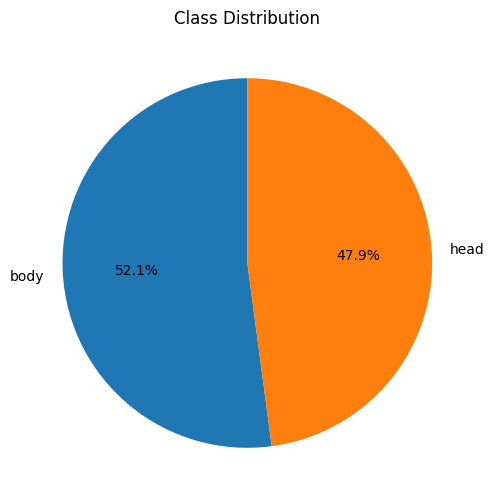

In [8]:
class_counts = labels_csv['class'].value_counts().reset_index()
class_counts.columns = ['class', 'count']

plt.figure(figsize=(8, 6))
plt.pie(class_counts['count'],
        labels=class_counts['class'],
        autopct='%1.1f%%', startangle=90)
plt.title("Class Distribution")

#### Split Train and Validation Set

In [9]:
boolean_labels = [label == unique_class for label in labels]
boolean_labels[77:80]

[array([False,  True]), array([ True, False]), array([False,  True])]

In [10]:
"""
Split train and validation data
Validation size %10 train size %90
"""
X = filenames
y = boolean_labels

train_images, valid_images, train_labels, valid_labels = train_test_split(filenames,
                                                                          boolean_labels,
                                                                          test_size=0.1,
                                                                          random_state=42)

len(train_images), len(train_labels), len(valid_images), len(valid_labels)

(556, 556, 62, 62)

### Turning images into Tensors


In [11]:
image = imread(filenames[0])
image.shape

(300, 535, 3)

In [12]:
IMG_SIZE = 300

def process_image(image_path, img_size=IMG_SIZE):
  """
  Takes an image file path and turns the image into a Tensor.
  """
  image = tf.io.read_file(image_path)
  image = tf.image.decode_jpeg(image, channels=3) #Normalization
  image = tf.image.convert_image_dtype(image, tf.float32)
  image = tf.image.resize(image, size=[IMG_SIZE, IMG_SIZE])
  return image

In [13]:
def get_image_and_label(image_path, label):
  """
  Takes an images file path and label, processes the image and
  returns a tuple of image,label
  """
  image = process_image(image_path)
  return image, label

In [14]:
BATCH_SIZE = 32

def create_data_batches(x, y=None, batch_size = BATCH_SIZE, valid_data= False, test_data = False):
  """
  Creates batches of data
  image(X) and label(y)
  Shuffles data  if it is training data
  Accept test data as input with no labels
  """

  if test_data:
    print("Creating test batches..")
    data = tf.data.Dataset.from_tensor_slices(tf.constant(x))
    data_batch = data.map(process_image).batch(BATCH_SIZE)
    return data_batch

  elif valid_data:
    print("Creating valid batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    return data_batch

  else:
    print("Creating train batches..")
    data = tf.data.Dataset.from_tensor_slices((tf.constant(x), tf.constant(y)))
    data = data.shuffle(buffer_size = len(x))
    data_batch = data.map(get_image_and_label).batch(BATCH_SIZE)
    return data_batch

In [15]:
train_data = create_data_batches(train_images, train_labels)
valid_data = create_data_batches(valid_images, valid_labels, valid_data=True)

Creating train batches..
Creating valid batches..


In [16]:
train_data.element_spec, valid_data.element_spec

((TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)),
 (TensorSpec(shape=(None, 300, 300, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, 2), dtype=tf.bool, name=None)))

### Visualizing Data Batches

In [17]:
def show_images(images, labels):
  """
  Display a plot of images and their labels from a data batch
  """
  plt.figure(figsize=(10,10))
  image_num = 9             #@param {type:"slider", min:1, max:50, step:1}
  for i in range(image_num):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i])
    plt.title(unique_class[labels[i].argmax()])
    plt.axis("off")


In [18]:
train_images, train_labels = next(train_data.as_numpy_iterator())
len(train_images), len(train_labels) #Batch Size

(32, 32)

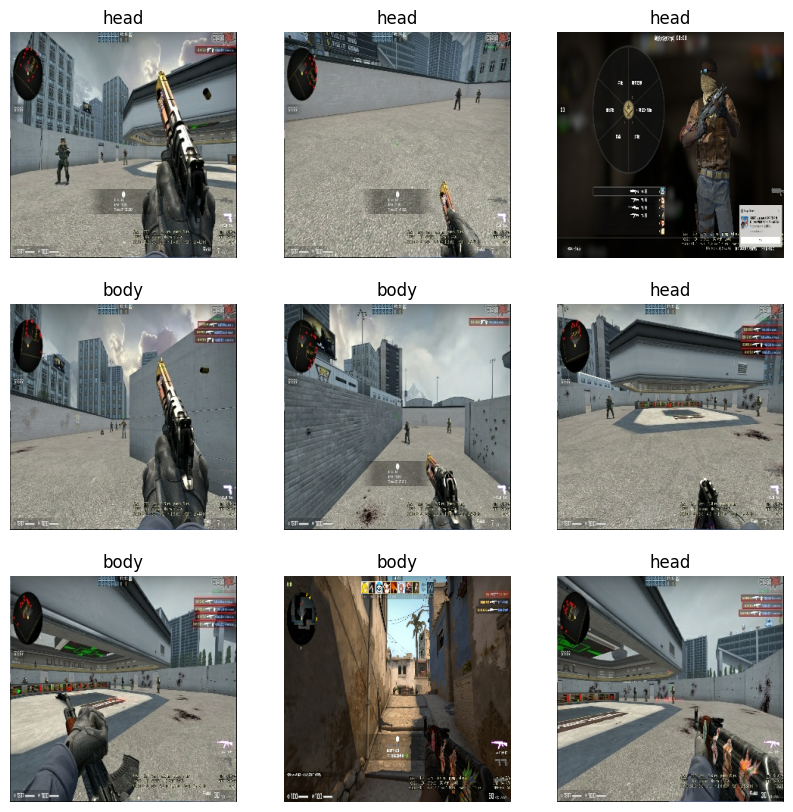

In [19]:
show_images(train_images,train_labels)

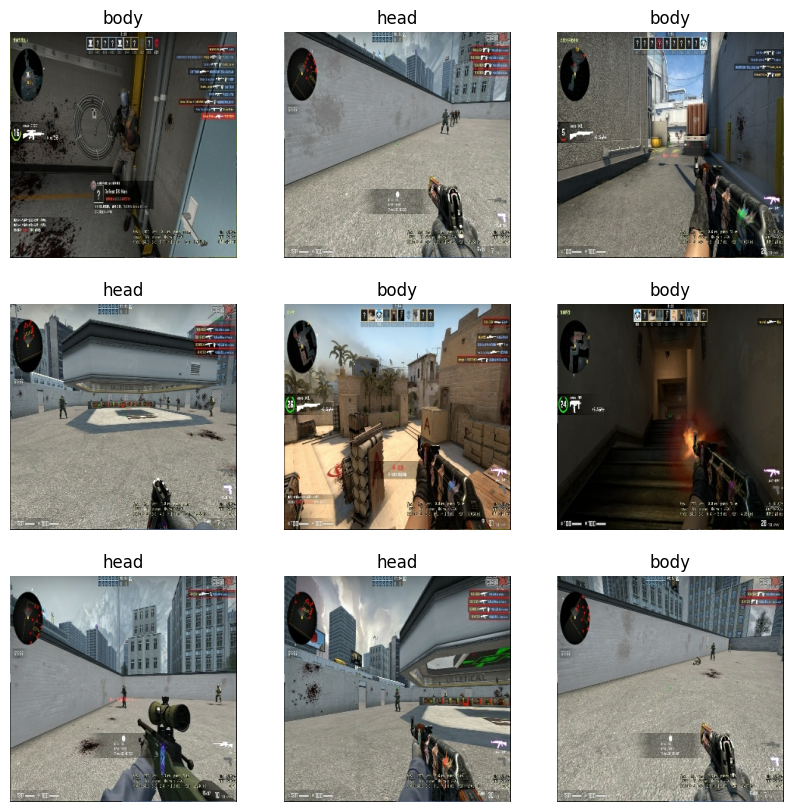

In [20]:
valid_images, valid_labels = next(valid_data.as_numpy_iterator())
show_images(valid_images, valid_labels)

## Create Model

In [21]:
INPUT_SHAPE = [32, IMG_SIZE, IMG_SIZE, 3] # batch, height, width, colour channels
OUTPUT_SHAPE = len(unique_class)

MODEL_URL =  "https://tfhub.dev/google/imagenet/inception_v2/classification/5"

In [22]:
def create_model(input_shape = INPUT_SHAPE, output_shape = OUTPUT_SHAPE, model_url = MODEL_URL):
  print("Building model with ", MODEL_URL)

  #Create Model Layers
  model = tf.keras.Sequential([
      hub.KerasLayer(MODEL_URL), #Layer 1
      tf.keras.layers.Dense(units = OUTPUT_SHAPE,
                            activation = "softmax") # Layer 2
  ])

  model.compile(
      loss = tf.keras.losses.CategoricalCrossentropy(),
      optimizer = tf.keras.optimizers.Adam(),
      metrics = ["accuracy"]
  )
  model.build(INPUT_SHAPE)

  return model

In [23]:
model = create_model()
model.summary()

Building model with  https://tfhub.dev/google/imagenet/inception_v2/classification/5
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (32, 1001)                11199137  
                                                                 
 dense (Dense)               (32, 2)                   2004      
                                                                 
Total params: 11201141 (42.73 MB)
Trainable params: 2004 (7.83 KB)
Non-trainable params: 11199137 (42.72 MB)
_________________________________________________________________


#### Callbasks

In [24]:
import datetime

def create_tensorboard_callback():
  logdir = os.path.join(DATA_DIR, datetime.datetime.now().strftime("%Y%m%d"))
  return tf.keras.callbacks.TensorBoard(logdir)

early_stopping = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=7)

## **TRAINING**

In [25]:
NUM_EPOCHS = 10

def train_model():
  """
  Trains a given model and returns the trained version.
  """
  model = create_model()
  tensorboard = create_tensorboard_callback()

  model.fit(x=train_data,
            epochs=NUM_EPOCHS,
            validation_data=valid_data,
            validation_freq=1, # check validation metrics every epoch
            callbacks=[tensorboard, early_stopping])

  return model

In [26]:
model = train_model()

Building model with  https://tfhub.dev/google/imagenet/inception_v2/classification/5
Epoch 1/10
18/18 [==============================] - 20s 484ms/step - loss: 0.7954 - accuracy: 0.4964 - val_loss: 0.8242 - val_accuracy: 0.5000
Epoch 2/10
18/18 [==============================] - 3s 185ms/step - loss: 0.7390 - accuracy: 0.4892 - val_loss: 0.7535 - val_accuracy: 0.5323
Epoch 3/10
18/18 [==============================] - 3s 167ms/step - loss: 0.7202 - accuracy: 0.5000 - val_loss: 0.7720 - val_accuracy: 0.4194
Epoch 4/10
18/18 [==============================] - 3s 176ms/step - loss: 0.7179 - accuracy: 0.4820 - val_loss: 0.7976 - val_accuracy: 0.4516
Epoch 5/10
18/18 [==============================] - 4s 214ms/step - loss: 0.7080 - accuracy: 0.5126 - val_loss: 0.7902 - val_accuracy: 0.4516
Epoch 6/10
18/18 [==============================] - 5s 240ms/step - loss: 0.7139 - accuracy: 0.5324 - val_loss: 0.7902 - val_accuracy: 0.4194
Epoch 7/10
18/18 [==============================] - 3s 184ms/s

In [27]:
%load_ext tensorboard
%tensorboard --logdir DATA_DIR ,datetime.datetime.now().strftime("%Y%m%d")

predictions = model.predict(valid_data, verbose=1)
predictions

ERROR: Failed to launch TensorBoard (exited with 2).
Contents of stderr:
2023-11-03 21:53:31.616507: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-03 21:53:31.616589: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-03 21:53:31.616617: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-03 21:53:32.589953: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
usage: tensorboard [-h] [--helpfull] [--logdir PATH] [--logdir_spec PATH_SPEC] [--host ADDR]
                   [--bind_all] [--port PORT] [--reuse_port BOOL] [--loa

2/2 [==============================] - 1s 169ms/step


array([[0.4023778 , 0.59762216],
       [0.5655915 , 0.4344085 ],
       [0.47070697, 0.529293  ],
       [0.60367405, 0.39632595],
       [0.55400974, 0.44599032],
       [0.3420811 , 0.6579189 ],
       [0.5675147 , 0.43248528],
       [0.5261131 , 0.47388688],
       [0.391593  , 0.60840696],
       [0.6354409 , 0.36455908],
       [0.7030728 , 0.2969272 ],
       [0.46988675, 0.5301132 ],
       [0.8550744 , 0.14492556],
       [0.5453678 , 0.45463222],
       [0.68505365, 0.31494638],
       [0.43399918, 0.5660008 ],
       [0.5655915 , 0.4344085 ],
       [0.4139934 , 0.58600664],
       [0.38246277, 0.6175372 ],
       [0.37376478, 0.62623525],
       [0.53367984, 0.4663202 ],
       [0.18051553, 0.8194844 ],
       [0.7143198 , 0.28568012],
       [0.3329301 , 0.6670699 ],
       [0.5933312 , 0.40666875],
       [0.59672105, 0.40327895],
       [0.49925682, 0.5007432 ],
       [0.36027455, 0.6397254 ],
       [0.4844072 , 0.5155929 ],
       [0.4751311 , 0.5248689 ],
       [0.

In [28]:
print(predictions[0])
print(f"Max value (probability of prediction): {np.max(predictions[0])}")
print(f"Sum: {np.sum(predictions[0])}")
print(f"Max index: {np.argmax(predictions[0])}")
print(f"Predicted label: {unique_class[np.argmax(predictions[0])]}")

[0.4023778  0.59762216]
Max value (probability of prediction): 0.5976221561431885
Sum: 1.0
Max index: 1
Predicted label: head


In [29]:
def get_class_name(prediction_probabilities):
  #Returns highest probability class name
  return unique_class[np.argmax(prediction_probabilities)]

prediction_labels = get_class_name(predictions[0])
prediction_labels

'head'

In [30]:
def unbatchify(data):
  """
  Since our validation data is in batch form,
  to get a list of validation images and labels,
  """
  images = []
  labels = []
  for image, label in data.unbatch().as_numpy_iterator():
    images.append(image)
    labels.append(unique_class[np.argmax(label)])
  return images, labels

valid_images, valid_labels = unbatchify(valid_data)
valid_images[0], valid_labels[0]

(array([[[1.88725501e-01, 2.02875823e-01, 1.10980399e-01],
         [1.35392159e-01, 1.39313728e-01, 1.09313734e-01],
         [1.22549035e-01, 1.26470596e-01, 9.54248533e-02],
         ...,
         [2.73855895e-01, 3.16993147e-01, 3.24836284e-01],
         [2.65294224e-01, 3.11666816e-01, 3.00097913e-01],
         [1.44835711e-01, 1.64966300e-01, 1.20129645e-01]],
 
        [[1.90424845e-01, 2.04575181e-01, 1.12679742e-01],
         [1.57352954e-01, 1.64509803e-01, 1.24803931e-01],
         [1.44934639e-01, 1.48856208e-01, 1.17810465e-01],
         ...,
         [2.77777463e-01, 3.20914716e-01, 3.28757852e-01],
         [2.69215792e-01, 3.15588385e-01, 3.10490161e-01],
         [1.80783749e-01, 2.00914338e-01, 1.56077668e-01]],
 
        [[2.04901978e-01, 2.20588252e-01, 1.20849684e-01],
         [1.37941182e-01, 1.45098045e-01, 1.05392165e-01],
         [1.41176477e-01, 1.45098045e-01, 1.14052296e-01],
         ...,
         [2.65849292e-01, 3.09476972e-01, 3.24672818e-01],
        

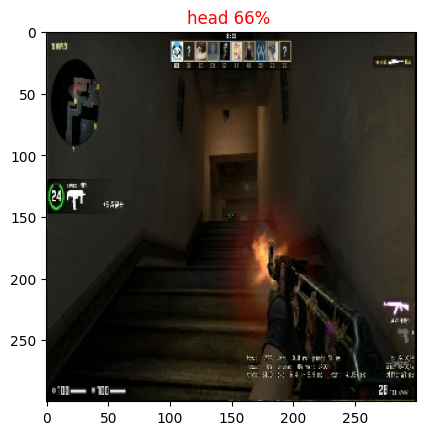

In [31]:
def plot_pred(prediction_probabilities, labels, images, n=5):
  """
  View the prediction, ground truth label and image for sample n.
  """
  pred_prob, true_label, image = prediction_probabilities[n], labels[n], images[n]
  prediction_label = get_class_name(pred_prob)

  plt.imshow(image)

  if prediction_label == true_label:
    color = "green"
  else:
    color = "red"

  plt.title("{} {:2.0f}% ".format(prediction_label,
                                  np.max(pred_prob)*100),
                                  color=color)

plot_pred(prediction_probabilities=predictions,
          labels=valid_labels,
          images=valid_images)

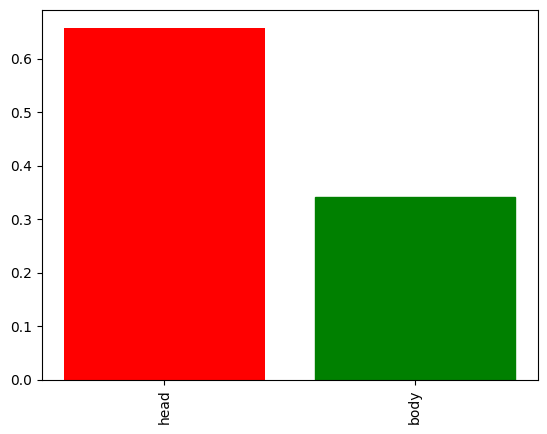

In [32]:
def plot_prediction_conf(prediction_probabilities, labels, n=1):
  """
  Prediction_probabilities: Array of prediction probabilities (e.g., model output)
  labels: Array of real labels
  n: Index position of the example to inspect

  This function generates a bar chart using prediction probabilities and real labels. It displays the probabilities of predicted classes in the chart and highlights the correct label in green.
  """

  pred_prob, true_label = prediction_probabilities[n], labels[n]
  pred_label = get_class_name(pred_prob)

  top_10_pred_indexes = pred_prob.argsort()[-5:][::-1]
  top_10_pred_values = pred_prob[top_10_pred_indexes]
  top_10_prediction_labels = unique_class[top_10_pred_indexes]

  top_plot = plt.bar(np.arange(len(top_10_prediction_labels)),
                     top_10_pred_values,
                     color="red")
  plt.xticks(np.arange(len(top_10_prediction_labels)),
             labels=top_10_prediction_labels,
             rotation="vertical")

  # Change color of true label
  if np.isin(true_label, top_10_prediction_labels):
    top_plot[np.argmax(top_10_prediction_labels == true_label)].set_color("green")
  else:
    pass

plot_prediction_conf(prediction_probabilities=predictions,
               labels=valid_labels,
               n=5)

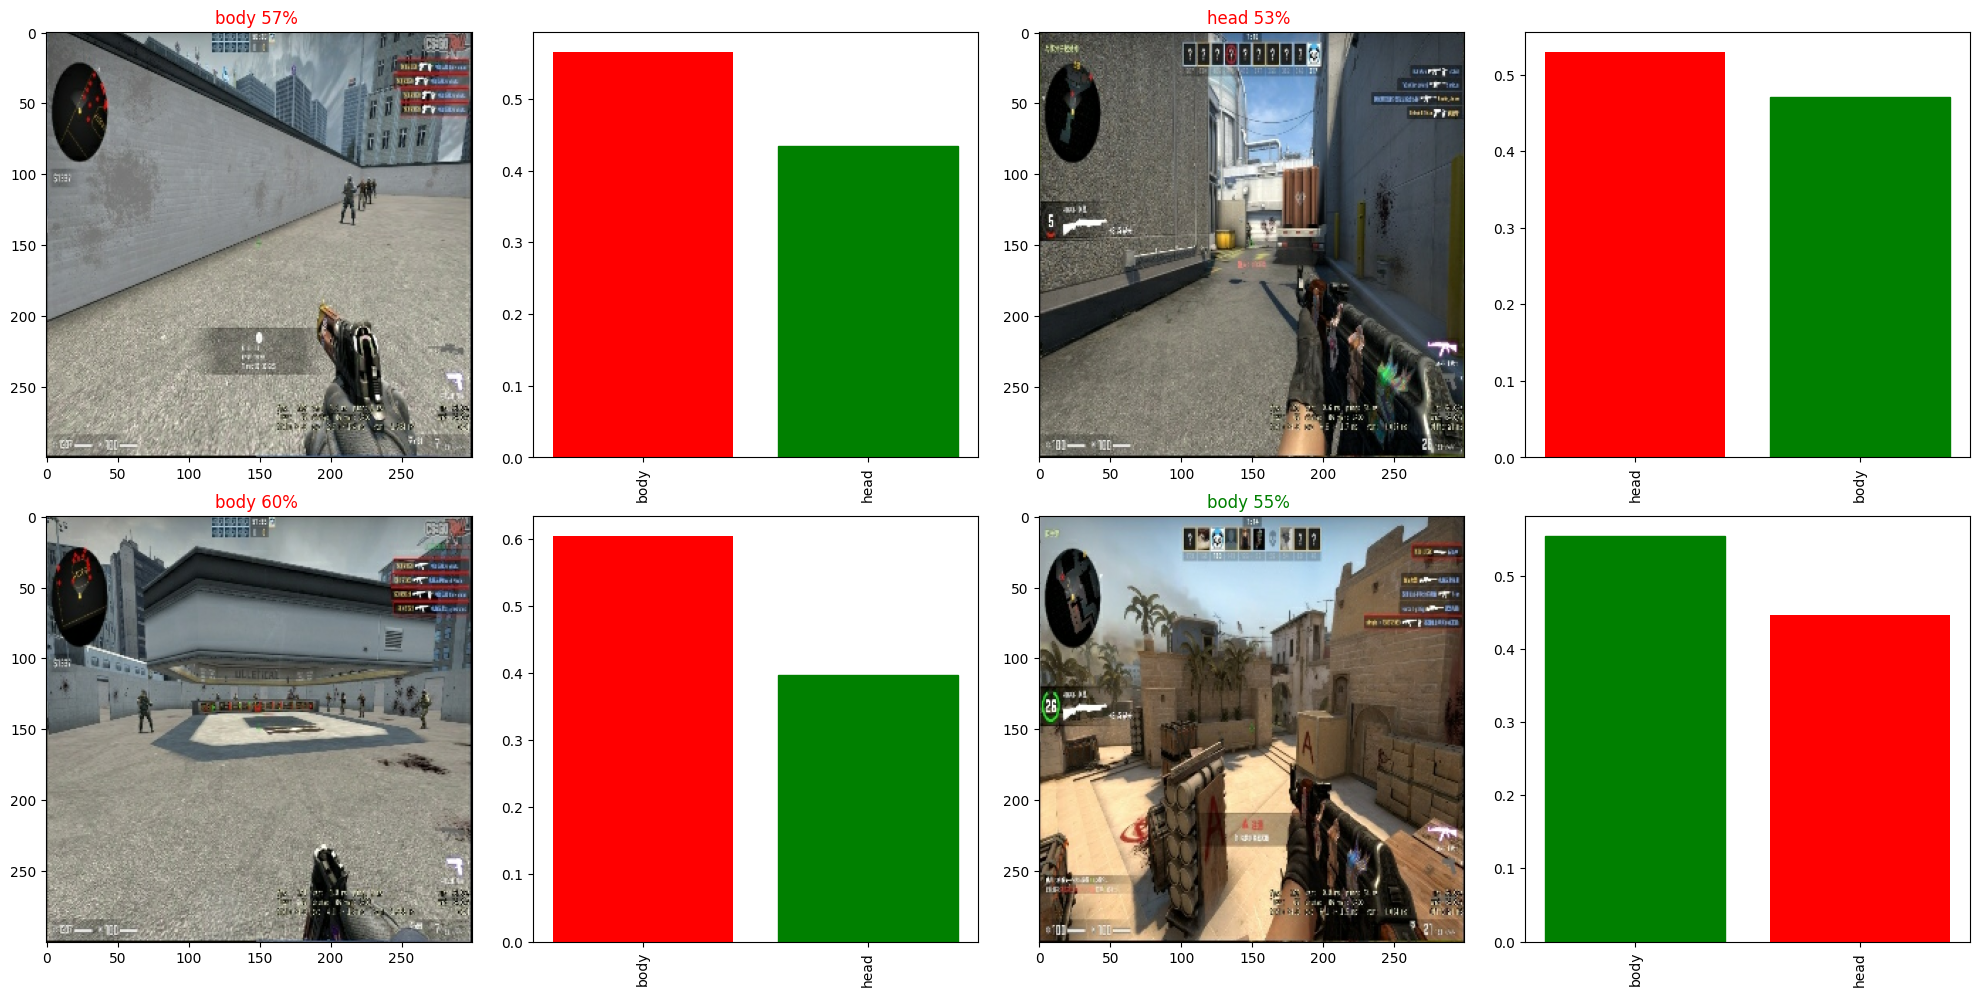

In [33]:
selective = 1
num_rows = 2
num_cols = 2

num_images = num_rows*num_cols # Total number of images to displa
plt.figure(figsize=(5*2*num_cols, 5*num_rows)) # Create a figure with a specified size

for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_pred(prediction_probabilities=predictions,
            labels=valid_labels,
            images=valid_images,
            n=i+selective)

  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_prediction_conf(prediction_probabilities=predictions,
                labels=valid_labels,
                n=i+selective)

plt.tight_layout(h_pad=1.0)
plt.show()

## SPLIT DATA EASY AND HARD

In [34]:
#Create csv file for hard examples
dark_object_csv = DATA_DIR + "/" + "dark_object.csv"
small_object_csv = DATA_DIR + "/" + "small_object.csv"
blur_object_csv = DATA_DIR + "/" + "blur_object.csv"

In [166]:
def parse_width_and_height_from_xml(xml_file_path):
  """
  Parsing width and height from XML Files
  """
  tree = ET.parse(xml_file_path)
  root = tree.getroot()
  width = int(root.find('size').find('width').text)
  height = int(root.find('size').find('height').text)

  return width, height

In [173]:
def small_object_detection(xml_file_path, min_width, min_height):
  """
  Function to detect small object
  """
  xmin, xmax, ymin, ymax = parse_pascal_voc_xml(xml_file_path)
  image_width, image_height = parse_width_and_height_from_xml(xml_file_path)

  object_width = int(xmax - xmin)
  object_height = int(ymax - ymin)

  if object_width < min_width or object_height < min_height:
      return True
  else:
    return False


In [174]:
def dark_detection(image_path):
  """
  Detects if an image is dark based on its average pixel intensity.

  Returns:
  - True: If the image is considered dark.
  - False: If the image is not considered dark.
  """
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  blur = cv2.blur(image, (5, 5))  # With kernel size depending upon image size
  mean_pixel = cv2.mean(blur)
  print("Darkness value:", mean_pixel[0])

  if mean_pixel[0] < 55:
    print("Dark image, Darkness value:", mean_pixel[0])
    return True
  else:
    return False

In [175]:
def blur_detection(image_path):
  """
  Function to detect blurry images.
  Detects if an image is blurry based on its Laplacian variance.
  """
  image = cv2.imread(image_path)
  gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  value = cv2.Laplacian(gray, cv2.CV_64F).var()
  print("Blur value:", value)

  if value < 600:
    print("Blurry image, Blur value:", value)
    return True

  else:
    print("Not blurry image")
    return False

In [179]:
def copy_removed_jpg_to_folder(removed_list, list_type):
    """
    Copying removed files to folder for check splitted data
    """
    list_name = "Check-" + list_type
    print("List name:", list_name)
    os.makedirs(DATA_DIR + list_name, exist_ok=True)

    for files in removed_list:
        if files.endswith(".jpg"):
            filename = os.path.basename(files)
            copy_dir = os.path.join(DATA_DIR+list_name, filename)
            shutil.copy(files, copy_dir)

        else:
            files_jpg_name = files.split("/")[-1].split(".")[0] + ".jpg"
            files_jpg = DATA_DIR + "/" + files_jpg_name
            print("XML List JPG Path:", files_jpg)
            filename = os.path.basename(files_jpg)
            copy_dir = os.path.join(DATA_DIR+list_name, filename)
            shutil.copy(files, copy_dir)


In [182]:
def parse_pascal_voc_xml(xml_file_path):

    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    annotations = []

    for obj in root.findall('object'):
        bbox = obj.find('bndbox')
        xmin = float(bbox.find('xmin').text)
        xmax = float(bbox.find('xmax').text)
        ymin = float(bbox.find('ymin').text)
        ymax = float(bbox.find('ymax').text)

    return xmin, xmax, ymin, ymax

In [186]:
small_object_list = []
dark_object_list = []
blur_object_list = []

for filename in os.listdir(DATA_DIR):
  xml_file_path = os.path.join(DATA_DIR, filename)

  if filename.endswith(".xml") and os.path.isfile(xml_file_path):
    is_small = small_object_detection(xml_file_path, 40, 60)

    if is_small == True:
      jpg_file_name = xml_file_path.split("/")[-1].split(".")[0] + ".jpg"
      jpg_file = DATA_DIR + "/" + jpg_file_name
      small_object_list.append(jpg_file)

for filename in os.listdir(DATA_DIR):
	jpg_file_path = os.path.join(DATA_DIR, filename)

	if filename.endswith(".jpg") and os.path.isfile(jpg_file_path):
		is_dark = dark_detection(jpg_file_path)
		is_blur = blur_detection(jpg_file_path)

		if is_dark == True:
				dark_object_list.append(jpg_file_path)

		elif is_blur == True:
				blur_object_list.append(jpg_file_path)

small_object_df = pd.DataFrame(small_object_list)
dark_object_df = pd.DataFrame(dark_object_list)
blur_object_df = pd.DataFrame(blur_object_list)

small_object_df.to_csv(small_object_csv)
print("\n\nSmall object CSV saved.")
dark_object_df.to_csv(dark_object_csv)
print("Dark object CSV saved.")
blur_object_df.to_csv(blur_object_csv)
print("Blur object CSV saved.")


copy_removed_jpg_to_folder(dark_object_list, "dark")
copy_removed_jpg_to_folder(blur_object_list, "blur")
copy_removed_jpg_to_folder(small_object_list, "small")


Small object detected! Width: 4 & Height: 7

Small object detected! Width: 7 & Height: 11

Small object detected! Width: 5 & Height: 5

Small object detected! Width: 3 & Height: 3

Small object detected! Width: 32 & Height: 14

Small object detected! Width: 5 & Height: 5

Small object detected! Width: 6 & Height: 5

Small object detected! Width: 20 & Height: 23

Small object detected! Width: 24 & Height: 25

Small object detected! Width: 20 & Height: 25

Small object detected! Width: 5 & Height: 5

Small object detected! Width: 14 & Height: 18

Small object detected! Width: 4 & Height: 5

Small object detected! Width: 4 & Height: 5

Small object detected! Width: 5 & Height: 7

Small object detected! Width: 7 & Height: 6

Small object detected! Width: 21 & Height: 34

Small object detected! Width: 3 & Height: 4

Small object detected! Width: 7 & Height: 6

Small object detected! Width: 39 & Height: 43

Small object detected! Width: 5 & Height: 6

Small object detected! Width: 37 & Heig

In [187]:
hard = pd.concat(["/content/drive/MyDrive/CS-body-head/dark_object.csv","/content/drive/MyDrive/CS-body-head/small_object.csv"])

TypeError: ignored